# Determine Best Simple Labeler for Silver Data

## Import

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import torch
import ast

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from tqdm import tqdm

## Read Data

In [2]:
train = "silverDataTraining.csv"
with open(train, "r") as f:
  train = pd.read_csv(f)
train.head()

,Task,Source,Target,Generated,ProbHall
0,MT,Не волнуйся. Это только временно.,Don't worry. It's only temporary.,"Don't worry, it's only temporary.",0.0
1,MT,"Тома никогда нет там, где он должен быть.",Tom is never where he's supposed to be.,Tom is never where he should be.,0.0
2,MT,Мне сложно работать с Томом.,I have trouble working with Tom.,It's hard for me to work with Tom.,0.0
3,MT,"Воду, пожалуйста.",I'd like some water.,"Water, please.",0.0
4,MT,"Я не ожидал, что Том предаст меня.",I didn't think that Tom would betray me.,I didn't expect Tom to betray me.,0.0


## Embed Everything with mBERT

Some of the source inputs will are in languages other than English. This is mostly the case for Machine Translation, and less so for DM and PG. That being said, for consistency, we use multi-lingual pre-trained embeddings for everything.

In [3]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
mBertModel = BertModel.from_pretrained('bert-base-multilingual-cased')

def embed(texts, batch_size, label):
  embeddings = []
  for i in tqdm(range(0, len(texts), batch_size), desc = label):
    tokenized = tokenizer(texts[i:i+batch_size], add_special_tokens=True, padding = True, return_tensors='pt', truncation = True, max_length = 512)
    with torch.no_grad():
        outputs = mBertModel(input_ids=tokenized['input_ids'], attention_mask=tokenized['attention_mask'])
    embeddings.extend(torch.mean(outputs.last_hidden_state, dim=1).tolist())
  return embeddings

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
embeddings = []
for task in train["Task"].unique():
  taskAdd = []
  taskDf = train[train["Task"] == task]
  for col in ["Source","Target","Generated"]:
    if taskDf[col].isnull().all():
      addDf = pd.DataFrame(np.nan, index = range(len(taskDf)), columns = [f"{col}_{i+1}" for i in range(768)])
    else:
      addDf = pd.DataFrame(embed(list(taskDf[col]), 50, f"{task}_{col}"), columns = [f"{col}_{i+1}" for i in range(768)])

    taskAdd.append(addDf)
  
  taskAdd = pd.concat(taskAdd, axis = 1)

  cols = ["Task"] + list(taskAdd.columns) + ["ProbHall"]
  taskAdd["ProbHall"] = list(taskDf["ProbHall"])
  taskAdd["Task"] = task
  taskAdd = taskAdd[cols]

  embeddings.append(taskAdd)
embeddings = pd.concat(embeddings, axis = 0)
embeddings.to_csv("silverDataTraining_embeddings.csv", index = False)

PG_Generated: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


In [5]:
embeddings.head()

,Task,Source_1,Source_2,Source_3,Source_4,Source_5,Source_6,Source_7,Source_8,Source_9,...,Generated_760,Generated_761,Generated_762,Generated_763,Generated_764,Generated_765,Generated_766,Generated_767,Generated_768,ProbHall
0,MT,0.113046,0.040308,0.820050,0.198808,0.256788,-0.102441,-0.230320,0.053201,0.012264,...,0.276380,-0.731403,-0.446825,0.221220,0.265931,-0.217736,0.090107,0.324381,0.650418,0.0
1,MT,-0.031885,-0.467381,0.452333,0.167855,0.165397,0.220628,-0.416896,0.097157,-0.189705,...,0.345975,0.124900,-0.145766,-0.192754,0.170115,0.037247,0.153456,-0.198518,0.123190,0.0
2,MT,-0.212962,-0.097734,0.306751,0.168145,0.110010,-0.288567,-0.047744,0.372212,0.107032,...,0.295755,-0.005443,-0.138040,0.494562,-0.327791,-0.055284,0.082710,0.046999,0.586870,0.0
3,MT,-0.093956,-0.199812,0.214371,-0.031817,0.264325,-0.278544,0.057553,-0.189225,0.323317,...,0.624036,-0.722551,-0.090941,0.880183,0.391491,0.138910,0.000684,0.037907,0.126560,0.0
4,MT,0.091205,-0.422646,0.686583,0.182609,0.274103,0.189996,-0.394072,0.052455,-0.022816,...,0.706456,-0.267629,0.243218,0.404932,-0.136323,-0.159888,-0.367346,0.418744,-0.082030,0.0


## Define Functions to Combine Vectors In Various Ways

In [6]:
def vectorCombine(X, method):
  if method == "mean":
    retDf = pd.DataFrame({f"{i+1}": X[[f"{col}_{i+1}" for col in ["Source","Target","Generated"]]].mean(axis = 1) for i in range(768)})
  elif method == "sum":
    retDf = pd.DataFrame({f"{i+1}": X[[f"{col}_{i+1}" for col in ["Source","Target","Generated"]]].sum(axis = 1) for i in range(768)})
  elif method == "max":
    retDf = pd.DataFrame({f"{i+1}": X[[f"{col}_{i+1}" for col in ["Source","Target","Generated"]]].max(axis = 1) for i in range(768)})
  elif method == "min":
    retDf = pd.DataFrame({f"{i+1}": X[[f"{col}_{i+1}" for col in ["Source","Target","Generated"]]].min(axis = 1) for i in range(768)})
  else:
    retDf = X.copy()

  return retDf.dropna(axis = 1)


## Setup Param Grids for Searching

In [7]:
params = {
    "LR":{
        "model":LogisticRegression(max_iter = 2000),
        "params":{
          'C': [0.001, 0.01, 0.1, 1, 10, 199],
          'solver': ['liblinear', 'lbfgs']
        }
    },
    "SVM":{
        "model":SVC(),
        "params":{
          'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': ['scale', 'auto']
        }
    },
    # "RF":{
    #     "model":RandomForestClassifier(),
    #     "params":{
    #       'n_estimators': [100, 200],
    #       'max_depth': [None, 10, 20],
    #       'min_samples_split': [2, 5,],
    #       'min_samples_leaf': [1, 2, 4]
    #     }
    # },
    "KNN":{
        "model":KNeighborsClassifier(),
        "params":{
          'n_neighbors': [2,4,6,8,10,12,14,16,18,20],
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    },
    # "NN":{
    #     "model":MLPClassifier(random_state = 1, max_iter = 5000),
    #     "params":{
    #       'hidden_layer_sizes': [(100,), (50, 50)],
    #       'activation': ['relu', 'tanh'],
    #       'solver': ['adam', 'sgd'],
    #       'alpha': [0.0001, 0.001],
    #     }

    # },
    # "GB":{
    #     "model":GradientBoostingClassifier(random_state = 1),
    #     "params":{
    #       'n_estimators': [50, 100],
    #       'learning_rate': [0.01, 0.1],
    #       'max_depth': [3, 5],
    #       'min_samples_split': [2, 5],
    #       'min_samples_leaf': [1, 2]
    #     }
    # }
}

## Initialize All of the Different Datasets to Test

In [8]:
testDfs = {task : embeddings[embeddings["Task"] == task].copy() for task in ["PG","DM","MT"]}

PG_withDM = testDfs["PG"].copy()
PG_withDM["Task"] = "PG_withDM"

newRows = []
for idx, row in testDfs["DM"].iterrows():
  newRows.append(["PG_withDM"] + [row[f"Target_{i+1}"] for i in range(768)] + [np.nan for i in range(768)] + [row[f"Generated_{i+1}"] for i in range(768)] + [row["ProbHall"]])

testDfs["PG_withDM"] = pd.concat([PG_withDM, pd.DataFrame(newRows, columns = PG_withDM.columns)], axis = 0)

for df in testDfs:
  testDfs[df] = testDfs[df].drop(columns = ["Task"])

# RUN ALL BEFORE HERE

## Run Tests

In [ ]:
results = []

prog_bar = tqdm(desc = "Testing", total = len(testDfs) * 5 * len(params))
for df in testDfs:
  data = testDfs[df]
  X = data.iloc[:, :-1]
  y = [round(v) for v in data.iloc[:,-1]]

  for combo in ["concat","sum","mean","max","min"]:
    X_combo = vectorCombine(X, combo)

    for model in params:
      prog_bar.update(1)
      m = params[model]["model"]
      p = params[model]["params"]

      grid_search = GridSearchCV(estimator=m, param_grid=p, cv=10, scoring='accuracy')
      grid_search.fit(np.array(X_combo), np.array(y))

      best_params = grid_search.best_params_
      best_acc = grid_search.best_score_

      results.append([df, combo, model, str(best_params), best_acc])
prog_bar.close()

results = pd.DataFrame(results, columns = ["task","comboMethod","model","bestParams","bestAccuracy"])

In [ ]:
results.to_csv("results.csv", index = False)
results.groupby("task", as_index = False).apply(lambda x: x.nlargest(1, columns="bestAccuracy"))

# Using Best Models For Each Task to Label Training Data

## Load in training data to be labeled

In [9]:
with open("results.csv", "r") as f:
  results = pd.read_csv(f).sort_values(by = "bestAccuracy", ascending = False)
results.head()

,task,comboMethod,model,bestParams,bestAccuracy
30,MT,concat,LR,"{'C': 0.1, 'solver': 'liblinear'}",0.835
44,MT,min,KNN,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",0.835
42,MT,min,LR,"{'C': 0.1, 'solver': 'lbfgs'}",0.835
41,MT,max,KNN,"{'algorithm': 'auto', 'n_neighbors': 16, 'weig...",0.835
35,MT,sum,KNN,"{'algorithm': 'auto', 'n_neighbors': 20, 'weig...",0.835


In [10]:
with open("train.csv", "r") as f:
  train = pd.read_csv(f)
train.head()

,src,tgt,hyp,task
0,Не волнуйся. Это только временно.,Don't worry. It's only temporary.,"Don't worry, it's only temporary.",MT
1,"Тома никогда нет там, где он должен быть.",Tom is never where he's supposed to be.,Tom is never where he should be.,MT
2,Мне сложно работать с Томом.,I have trouble working with Tom.,It's hard for me to work with Tom.,MT
3,"Воду, пожалуйста.",I'd like some water.,"Water, please.",MT
4,"Я не ожидал, что Том предаст меня.",I didn't think that Tom would betray me.,I didn't expect Tom to betray me.,MT


## Embed with mBERT embeddings (take a LONG time)

In [ ]:
embedBS = 500
for idx in tqdm(range(0, len(train), embedBS), desc = "Batched Embedding"):
  train_batch = train.iloc[idx:idx+embedBS]

  embeddings = None
  for task in train_batch["task"].unique():
    taskAdd = None
    taskDf = train_batch[train_batch["task"] == task].copy()
    for col in ["src","tgt","hyp"]:
      if task == "PG" and col == "tgt":
        addDf = pd.DataFrame(np.nan, index = range(len(taskDf)), columns = [f"{col}_{i+1}" for i in range(768)])
      else:
        taskDf[col].fillna(" ",inplace = True)
        addDf = pd.DataFrame(embed(list(taskDf[col]), 100, f"  {task}_{col}"), columns = [f"{col}_{i+1}" for i in range(768)])

      if type(taskAdd) == None:
        taskAdd = addDf
      else:
        taskAdd = pd.concat([taskAdd, addDf], axis = 1)

    cols = ["Task"] + list(taskAdd.columns)
    taskAdd["Task"] = task
    taskAdd = taskAdd[cols]

    if type(embeddings) == None:
      embeddings = taskAdd
    else:
      embeddings = pd.concat([embeddings, taskAdd], axis = 0)
  
  embeddings.to_csv(f"embeddingBatches/{idx}-to-{idx + embedBS}.csv", index = False)

## Read in Embeddings

In [11]:
embedBS = 500
embeddingDf = []
for idx in tqdm(range(0, len(train), embedBS), desc = "Loading Batches"):
    file = f"embeddingBatches/{idx}-to-{idx + embedBS}.csv"
    with open(file, "r") as f:
        batchDf = pd.read_csv(f)

    embeddingDf.append(batchDf)

embeddingDf = pd.concat(embeddingDf, ignore_index=True)
embeddingDf.head()

Loading Batches: 100%|██████████| 120/120 [00:31<00:00,  3.78it/s]


,Task,src_1,src_2,src_3,src_4,src_5,src_6,src_7,src_8,src_9,...,hyp_759,hyp_760,hyp_761,hyp_762,hyp_763,hyp_764,hyp_765,hyp_766,hyp_767,hyp_768
0,MT,0.109252,0.057483,0.802601,0.208838,0.249414,-0.129708,-0.242336,0.034030,0.011627,...,0.051506,0.236455,-0.660653,-0.390232,0.233197,0.239963,-0.217637,0.058422,0.304913,0.596060
1,MT,-0.051133,-0.427608,0.450796,0.179057,0.174077,0.207216,-0.396545,0.087700,-0.146154,...,0.168625,0.285358,0.107645,-0.001767,-0.198388,0.185259,0.070109,0.154034,-0.180205,0.124891
2,MT,-0.242393,-0.079607,0.310807,0.147237,0.121589,-0.295707,-0.054048,0.376617,0.109469,...,0.318253,0.219723,-0.010270,-0.132629,0.473706,-0.301863,0.000637,0.039474,0.042764,0.518656
3,MT,-0.084274,-0.184405,0.214719,-0.052711,0.241330,-0.289727,0.079595,-0.178912,0.311439,...,0.157983,0.569756,-0.707462,-0.075542,0.858098,0.350855,0.150486,-0.020335,0.055133,0.113272
4,MT,0.090243,-0.398365,0.684933,0.182516,0.258035,0.174206,-0.372207,0.031476,-0.009302,...,-0.252302,0.655680,-0.230803,0.251993,0.413486,-0.152881,-0.154417,-0.329462,0.400603,-0.088634


In [12]:
embeddingDf = pd.concat([train.drop(columns = "task"), embeddingDf], axis = 1)
embeddingDf.rename(columns = {c:c.replace("hyp","Generated") for c in embeddingDf.columns if "hyp" in c}, inplace = True)
embeddingDf.rename(columns = {c:c.replace("src","Source") for c in embeddingDf.columns if "src" in c}, inplace = True)
embeddingDf.rename(columns = {c:c.replace("tgt","Target") for c in embeddingDf.columns if "tgt" in c}, inplace = True)
embeddingDf.head()

,Source,Target,Generated,Task,Source_1,Source_2,Source_3,Source_4,Source_5,Source_6,...,Generated_759,Generated_760,Generated_761,Generated_762,Generated_763,Generated_764,Generated_765,Generated_766,Generated_767,Generated_768
0,Не волнуйся. Это только временно.,Don't worry. It's only temporary.,"Don't worry, it's only temporary.",MT,0.109252,0.057483,0.802601,0.208838,0.249414,-0.129708,...,0.051506,0.236455,-0.660653,-0.390232,0.233197,0.239963,-0.217637,0.058422,0.304913,0.596060
1,"Тома никогда нет там, где он должен быть.",Tom is never where he's supposed to be.,Tom is never where he should be.,MT,-0.051133,-0.427608,0.450796,0.179057,0.174077,0.207216,...,0.168625,0.285358,0.107645,-0.001767,-0.198388,0.185259,0.070109,0.154034,-0.180205,0.124891
2,Мне сложно работать с Томом.,I have trouble working with Tom.,It's hard for me to work with Tom.,MT,-0.242393,-0.079607,0.310807,0.147237,0.121589,-0.295707,...,0.318253,0.219723,-0.010270,-0.132629,0.473706,-0.301863,0.000637,0.039474,0.042764,0.518656
3,"Воду, пожалуйста.",I'd like some water.,"Water, please.",MT,-0.084274,-0.184405,0.214719,-0.052711,0.241330,-0.289727,...,0.157983,0.569756,-0.707462,-0.075542,0.858098,0.350855,0.150486,-0.020335,0.055133,0.113272
4,"Я не ожидал, что Том предаст меня.",I didn't think that Tom would betray me.,I didn't expect Tom to betray me.,MT,0.090243,-0.398365,0.684933,0.182516,0.258035,0.174206,...,-0.252302,0.655680,-0.230803,0.251993,0.413486,-0.152881,-0.154417,-0.329462,0.400603,-0.088634


## Load Parameters for Best Model

In [13]:
bestResultsByTask = results.groupby("task", as_index = False).apply(lambda x: x.nlargest(1, columns="bestAccuracy"))
bestResultsByTask

,,task,comboMethod,model,bestParams,bestAccuracy
0,29,DM,min,KNN,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",0.6850
1,30,MT,concat,LR,"{'C': 0.1, 'solver': 'liblinear'}",0.8350
2,2,PG,concat,KNN,"{'algorithm': 'auto', 'n_neighbors': 6, 'weigh...",0.6700
3,59,PG_withDM,min,KNN,"{'algorithm': 'auto', 'n_neighbors': 14, 'weig...",0.6475


We see that combining PG and DM to provide more training data for PG does not yield the improvement we hoped for, so we can simply ignore it.

In [14]:
bestResultsByTask = bestResultsByTask[bestResultsByTask["task"] != "PG_withDM"]
bestResultsByTask

,,task,comboMethod,model,bestParams,bestAccuracy
0,29,DM,min,KNN,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",0.685
1,30,MT,concat,LR,"{'C': 0.1, 'solver': 'liblinear'}",0.835
2,2,PG,concat,KNN,"{'algorithm': 'auto', 'n_neighbors': 6, 'weigh...",0.670


In [15]:
bestModels = {}
for idx, row in bestResultsByTask.iterrows():
    bestModels[row["task"]] = {
        "model":params[row["model"]]["model"].set_params(**ast.literal_eval(row["bestParams"])),
        "combo":row["comboMethod"],
    }

In [16]:
embeddingDf.head()

,Source,Target,Generated,Task,Source_1,Source_2,Source_3,Source_4,Source_5,Source_6,...,Generated_759,Generated_760,Generated_761,Generated_762,Generated_763,Generated_764,Generated_765,Generated_766,Generated_767,Generated_768
0,Не волнуйся. Это только временно.,Don't worry. It's only temporary.,"Don't worry, it's only temporary.",MT,0.109252,0.057483,0.802601,0.208838,0.249414,-0.129708,...,0.051506,0.236455,-0.660653,-0.390232,0.233197,0.239963,-0.217637,0.058422,0.304913,0.596060
1,"Тома никогда нет там, где он должен быть.",Tom is never where he's supposed to be.,Tom is never where he should be.,MT,-0.051133,-0.427608,0.450796,0.179057,0.174077,0.207216,...,0.168625,0.285358,0.107645,-0.001767,-0.198388,0.185259,0.070109,0.154034,-0.180205,0.124891
2,Мне сложно работать с Томом.,I have trouble working with Tom.,It's hard for me to work with Tom.,MT,-0.242393,-0.079607,0.310807,0.147237,0.121589,-0.295707,...,0.318253,0.219723,-0.010270,-0.132629,0.473706,-0.301863,0.000637,0.039474,0.042764,0.518656
3,"Воду, пожалуйста.",I'd like some water.,"Water, please.",MT,-0.084274,-0.184405,0.214719,-0.052711,0.241330,-0.289727,...,0.157983,0.569756,-0.707462,-0.075542,0.858098,0.350855,0.150486,-0.020335,0.055133,0.113272
4,"Я не ожидал, что Том предаст меня.",I didn't think that Tom would betray me.,I didn't expect Tom to betray me.,MT,0.090243,-0.398365,0.684933,0.182516,0.258035,0.174206,...,-0.252302,0.655680,-0.230803,0.251993,0.413486,-0.152881,-0.154417,-0.329462,0.400603,-0.088634


## Label All Training Data

In [17]:
silverData_subsets = []
for task in ["DM","PG","MT"]:

    comboMethod = bestResultsByTask[bestResultsByTask["task"] == task]["comboMethod"].iloc[0]

    # retrain model with optimal params
    data = testDfs[task]
    X = data.dropna(axis = 1).iloc[:, :-1]
    y = [round(v) for v in data.iloc[:,-1]]
    bestModels[task]["model"].fit(np.array(vectorCombine(X, comboMethod)),y)

    embeddingSubset = embeddingDf[embeddingDf["Task"] == task]
    textDf = embeddingSubset[["Source","Target","Generated","Task"]].copy()
    X_silver = embeddingSubset[[c for c in embeddingSubset.columns if c not in textDf.columns]].copy()

    textDf["ProbHall"] = bestModels[task]["model"].predict_proba(np.array(vectorCombine(X_silver, comboMethod)))[:,1]
    silverData_subsets.append(textDf)
silverData = pd.concat(silverData_subsets).sort_index()
silverData.to_csv("silverData.csv", index = False)
silverData.head()

,Source,Target,Generated,Task,ProbHall
0,Не волнуйся. Это только временно.,Don't worry. It's only temporary.,"Don't worry, it's only temporary.",MT,0.105953
1,"Тома никогда нет там, где он должен быть.",Tom is never where he's supposed to be.,Tom is never where he should be.,MT,0.070797
2,Мне сложно работать с Томом.,I have trouble working with Tom.,It's hard for me to work with Tom.,MT,0.054526
3,"Воду, пожалуйста.",I'd like some water.,"Water, please.",MT,0.032572
4,"Я не ожидал, что Том предаст меня.",I didn't think that Tom would betray me.,I didn't expect Tom to betray me.,MT,0.071077


## ROC Curves

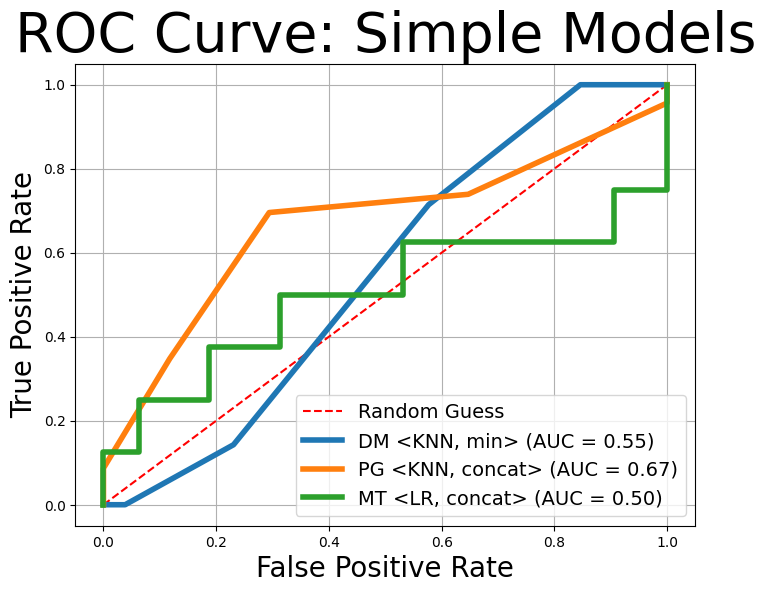

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

with open("silverDataTraining_embeddings.csv","r") as f:
    sd_train = pd.read_csv(f)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')

for task in ["DM","PG","MT"]:

    comboMethod = bestResultsByTask[bestResultsByTask["task"] == task]["comboMethod"].iloc[0]
    name = bestResultsByTask[bestResultsByTask["task"] == task]["model"].iloc[0]
    # retrain model with optimal params
    data = sd_train[sd_train["Task"] == task]
    X = data.dropna(axis = 1).iloc[:, 1:-1]
    X = vectorCombine(X, comboMethod)
    y = [round(v) for v in data.iloc[:,-1]]

    X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=1)
    bestModels[task]["model"].fit(X_train,y_train)

    pred = bestModels[task]["model"].predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    plt.plot(fpr, tpr, label=f'{task} <{name}, {comboMethod}> (AUC = {auc:.2f})', lw = 4)

plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Curve: Simple Models', fontsize = 40)
plt.legend(fontsize = 14, loc = "lower right")
plt.grid(True)
plt.show()